# Final Document for Data Analysis 

In [41]:
# Importing the necessary packages and the given CSVs as dataframes
import pandas as pd
import sqldf
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", UserWarning)

cd= pd.read_csv('customer_data.csv') #Uploading customer data as a dataframe cd

od= pd.read_csv('order_data.csv') #Uploading order data as a dataframe od

opd= pd.read_csv('order_product_data.csv') #Uploading order product data as a dataframe opd

prod= pd.read_csv('product_data.csv') #Uploading product data as a dataframe prod

# I. Getting to Know the Data

- At first I played around with the data to understand more about the data. 
- You can find some of the functions I used to learn more about the data in `RoughWork.ipynb`. You can skip looking through `RoughWork.ipynb` as it is not related to my analysis. 

## Takeaways from the Datasets Provided
- I noticed there is no cost related data. So, any cost and profit calculations (Customer Lifetime Value (CLV), cost of customer acquisition etc) couldn’t be done accurately. 
- However, there is sufficient data to calculate sales-related KPIs such as Average Order Value (AOV)
- There is also operational data (such as Shipping Times). This data can be used to analyze opportunities of improvement internally.

## Outliers and Decision Making
- The data ranges from the times Sept 2016 to Oct 2018 (almost exactly 2 years). In some of my analysis, I decided to break up the data into months to show trend month over month.
- There is a large variance from normal in the number of orders betweeen `09-2016 to 12-2016` and `09-2018 to 10-2018`. As this is distracting from the story in the presentation, these time periods have been removed from some visualizations. This discrepancy and the reasoning behind this decision is further addressed below. 


# II. Calculations Used in Presentation
## (i). Calculating Trend in Average Order Value (AOV)
- AOV = Revenue/# of Orders
- First, I will make a new dataframe odmy (order data month year) where it is the order_data with another column month-year of purchased_at. This will help with future trend evaluations.

In [42]:
# Define a SQL (SQLite3) query
query = """
SELECT *, strftime('%m-%Y', purchased_at) as MonthYear
from od
"""

# Run and/or print the query
odmy = sqldf.run(query) #Order data with the MonthYear column

In [43]:
# Querying the number of non-cancelled orders over each Month-Year period

# Define a SQL (SQLite3) query
query = """
SELECT count(distinct(order_id)), MonthYear
from odmy
where order_status!='canceled'
group by MonthYear
order by strftime('%Y', purchased_at), strftime('%m', purchased_at)
"""

# Run and/or print the query
df_view = sqldf.run(query) #Order data with the MonthYear column
print(df_view)

    count(distinct(order_id)) MonthYear
0                           2   09-2016
1                         300   10-2016
2                           1   12-2016
3                         797   01-2017
4                        1763   02-2017
5                        2649   03-2017
6                        2386   04-2017
7                        3671   05-2017
8                        3229   06-2017
9                        3998   07-2017
10                       4304   08-2017
11                       4265   09-2017
12                       4605   10-2017
13                       7507   11-2017
14                       5662   12-2017
15                       7235   01-2018
16                       6655   02-2018
17                       7185   03-2018
18                       6924   04-2018
19                       6849   05-2018
20                       6149   06-2018
21                       6251   07-2018
22                       6428   08-2018
23                          1   09-2018


## Insights
- There seems to be a large drop off in # of orders in `09-2016`, `10-2016`,`12-2016`, `09-2018`
- `11-2016` and `10-2018` are completely missing from non-cancelled orders. 
- The 2016 trend is not on par with industry trends as Black Friday and Holiday Season is the biggest time in e-commerce. However, since Bonsai started in 2016, this variance can possibly be attributed to growing pains. Thus, we can drop this time period from some of our presentation analysis.
- `09-2018` and `10-2018` are still unexplained. Could be data migration errors, or some other internal factor.
- The drop off in `09-2018` and `10-2018` is so significant that the assumption is the team at Bonsai would have immediately noticed it and deep-dived into the cause. Thus, this drop-off in orders is not something that needs to be addressed at a C-Suite presentation as they would already be aware. 

In [44]:
# Querying Trend in Price and Shipping Revenue over Each Month (sans cancelled orders)
# Define a SQL (SQLite3) query
query = """
SELECT sum(opd.price) as Price, sum(opd.shipping) as Shipping, count(distinct(odmy.order_id)) NumOrders,
        ((sum(opd.price)+sum(opd.shipping))/count(distinct(odmy.order_id))) as AOV, MonthYear
from opd
left join odmy
on odmy.order_id=opd.order_id 
where order_status!='canceled'
group by MonthYear
order by strftime('%Y', purchased_at), strftime('%m', purchased_at)
"""

# Run and/or print the query
df_view = sqldf.run(query) 
print(df_view)

         Price   Shipping  NumOrders         AOV MonthYear
0       207.86      71.83          2  139.845000   09-2016
1     46514.99    6980.02        296  180.726385   10-2016
2        10.90       8.72          1   19.620000   12-2016
3    120098.27   16845.19        787  174.006938   01-2017
4    244959.35   38602.34       1718  165.053370   02-2017
5    368341.32   57276.64       2617  162.635827   03-2017
6    353842.98   52005.63       2377  170.739844   04-2017
7    503159.19   79551.64       3640  160.085393   05-2017
8    429916.61   69735.63       3205  155.897735   06-2017
9    492287.30   86466.43       3946  146.668457   07-2017
10   568245.79   93657.73       4272  154.939963   08-2017
11   621415.91   95686.81       4227  169.648148   09-2017
12   660179.62  104576.41       4547  168.189142   10-2017
13  1003862.14  168329.54       7421  157.956027   11-2017
14   742183.79  119342.98       5618  153.351152   12-2017
15   945456.29  156463.72       7187  153.321276   01-20

## Visualization of AOV Trend

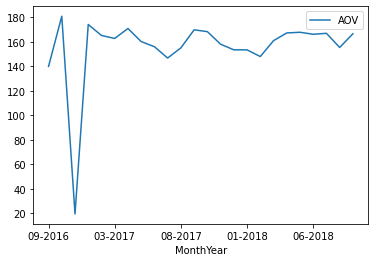

In [45]:
df_view.plot(x ='MonthYear', y='AOV', kind = 'line')

plt.show()

## Insights 
- Ignoring the outlier in the beginning months (attributed to growing pains), AOV seems pretty stagnant over the months.
- Area to improve. Company can focus on increasing AOV.
- There are some orders from Order Data that are not listed in Order Product Data. Miniscule difference.

## (iii). Calculating Trend in Customer Spend Month over Month
- Included shipping in the revenue

In [46]:
# Customer Spend labelled as revenue
# Define a SQL (SQLite3) query
query = """
SELECT sum(opd.price)+sum(opd.shipping) as Revenue, odmy.MonthYear
from opd
left join odmy
on opd.order_id=odmy.order_id
where odmy.order_status!='canceled'
group by odmy.MonthYear
order by strftime('%Y', odmy.purchased_at), strftime('%m', odmy.purchased_at)
"""

# Run and/or print the query
df_view = sqldf.run(query) 
print(df_view)

       Revenue MonthYear
0       279.69   09-2016
1     53495.01   10-2016
2        19.62   12-2016
3    136943.46   01-2017
4    283561.69   02-2017
5    425617.96   03-2017
6    405848.61   04-2017
7    582710.83   05-2017
8    499652.24   06-2017
9    578753.73   07-2017
10   661903.52   08-2017
11   717102.72   09-2017
12   764756.03   10-2017
13  1172191.68   11-2017
14   861526.77   12-2017
15  1101920.01   01-2018
16   979486.16   02-2018
17  1152656.99   03-2018
18  1156248.89   04-2018
19  1145686.46   05-2018
20  1020381.90   06-2018
21  1039783.58   07-2018
22   996973.51   08-2018
23      166.46   09-2018


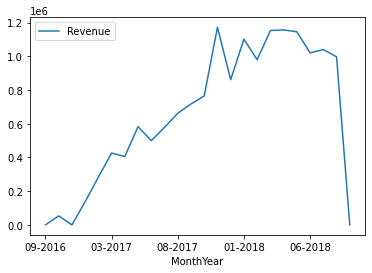

In [47]:
df_view.plot(x ='MonthYear', y='Revenue', kind = 'line')

plt.show()

## Insights
- Ignoring outliers, revenue is growing Year over Year

## (iii). Calculating Percent Returning Customers
- Percent Returning Customers is an indicator of Customer Lifetime Value (CLV)
- Percent Returning Customers = (# of Returning Customers / # Total Customers) * 100

In [48]:
# # of Total Customers with at least one non-cancelled order
# Define a SQL (SQLite3) query
query = """
SELECT count(distinct(customer_unique_id))
from cd
left join odmy
on cd.customer_order_id=odmy.customer_order_id
where odmy.order_Status!='canceled'
"""

# Run and/or print the query
df_view = sqldf.run(query) 
print(df_view)

   count(distinct(customer_unique_id))
0                                95560


## Total Customers with At Least 1 Non-Cancelled Order: 95,560

In [49]:
# Querying all customers with more than 1 non-cancelled order_id
# Define a SQL (SQLite3) query
query = """
SELECT cd.customer_unique_id, count(distinct(odmy.order_id))
from odmy
left join cd
on cd.customer_order_id=odmy.customer_order_id
where odmy.order_status!='canceled'
group by cd.customer_unique_id
having count(distinct(odmy.order_id))>1
order by count(distinct(odmy.order_id)) desc
"""

# Run and/or print the query
df_view = sqldf.run(query) 
print(df_view)

                    customer_unique_id  count(distinct(odmy.order_id))
0     8d50f5eadf50201ccdcedfb9e2ac8455                              17
1     3e43e6105506432c953e165fb2acf44c                               9
2     ca77025e7201e3b30c44b472ff346268                               7
3     6469f99c1f9dfae7733b25662e7f1782                               7
4     1b6c7548a2a1f9037c1fd3ddfed95f33                               7
...                                ...                             ...
2919  011575986092c30523ecb71ff10cb473                               2
2920  00cc12a6d8b578b8ebd21ea4e2ae8b27                               2
2921  00a39521eb40f7012db50455bf083460                               2
2922  004b45ec5c64187465168251cd1c9c2f                               2
2923  004288347e5e88a27ded2bb23747066c                               2

[2924 rows x 2 columns]


## Returning customers: 2,924

In [50]:
#Calculating Percent Returning Customers 
PercentReturningCustomers = (2924/95560)*100
print(PercentReturningCustomers)

3.0598576810380913


## Percent Returning Customers: 3.06%
## Insights
- Only 3% of customers are return customers. 
- Compared to industry average, there is huge opportunity to increase this number.
- Possibly need to focus our efforts on retargeting channels - ads, newsletters, email marketing

# III. Calculations Not Directly Used in Presentation
## (i). Calculating Trend in Shipping Price/Total Price Month over Month

In [51]:
# Define a SQL (SQLite3) query
query = """
SELECT (sum(opd.shipping)/sum(opd.shipping + opd.price))*100 as ShippingRate, sum(opd.shipping) as ShippingPrice, sum(opd.price) as ProductPrice, sum(opd.shipping + opd.price) as TotalPrice, MonthYear
from opd
left join odmy
on opd.order_id=odmy.order_id
group by MonthYear
order by strftime('%Y', purchased_at), strftime('%m', purchased_at)

"""

# Run and/or print the query
df_view = sqldf.run(query) 
print(df_view)

    ShippingRate  ShippingPrice  ProductPrice  TotalPrice MonthYear
0      24.634249          87.39        267.36      354.75   09-2016
1      12.852190        7301.18      49507.66    56808.84   10-2016
2      44.444444           8.72         10.90       19.62   12-2016
3      12.301047       16875.62     120312.87   137188.49   01-2017
4      13.615172       38977.60     247303.02   286280.62   02-2017
5      13.355972       57704.29     374344.30   432048.59   03-2017
6      12.728462       52495.01     359927.23   412422.24   04-2017
7      13.667869       80119.81     506071.14   586190.95   05-2017
8      13.902501       69924.44     433038.60   502963.04   06-2017
9      14.862283       86940.14     498031.48   584971.62   07-2017
10     14.102405       94232.92     573971.68   668204.60   08-2017
11     13.325564       95997.22     624401.69   720398.91   09-2017
12     13.660633      105092.94     664219.43   769312.37   10-2017
13     14.321612      168872.40    1010271.37  1

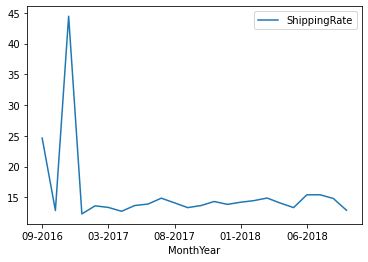

In [52]:
df_view.plot(x ='MonthYear', y='ShippingRate', kind = 'line')

plt.show()

## Insights
- Ignoring the outliers, shipping rate seems to be quite constant
- How does the rate compare to industry average? 
- Will it help us increase purchase conversion if we reduce shipping rate?

## (ii). Calculating Spend by Category
- Cancelled orders are included in this query, but they shouldn't have a large effect on the key takeaways

In [53]:
# Spend by Category, from highest to lowest (includes cancelled orders)
# Define a SQL (SQLite3) query
query = """
SELECT sum(opd.price) as ProductPrice, prod.category
from opd
left join prod
on opd.product_id=prod.product_id
group by prod.category
order by sum(opd.price) desc
"""

# Run and/or print the query
df_view = sqldf.run(query) 
print(df_view)

    ProductPrice                  category
0     1906392.96                 furniture
1     1258681.34             health_beauty
2     1206252.65                      home
3     1205005.68                   watches
4      988048.97                    sports
5      911954.32     computers_accessories
6      685461.84             miscellaneous
7      592720.11                      auto
8      485256.46              garden_tools
9      483946.60                      toys
10     413332.48                      baby
11     399124.87                 perfumery
12     383250.53                    phones
13     273960.70          office_furniture
14     238471.64                stationery
15     226302.11        construction_tools
16     222963.13                 computers
17     214315.41                  pet_shop
18     204262.62                     music
19     185049.76                      None
20     160246.74               electronics
21     157465.22                     games
22     1528

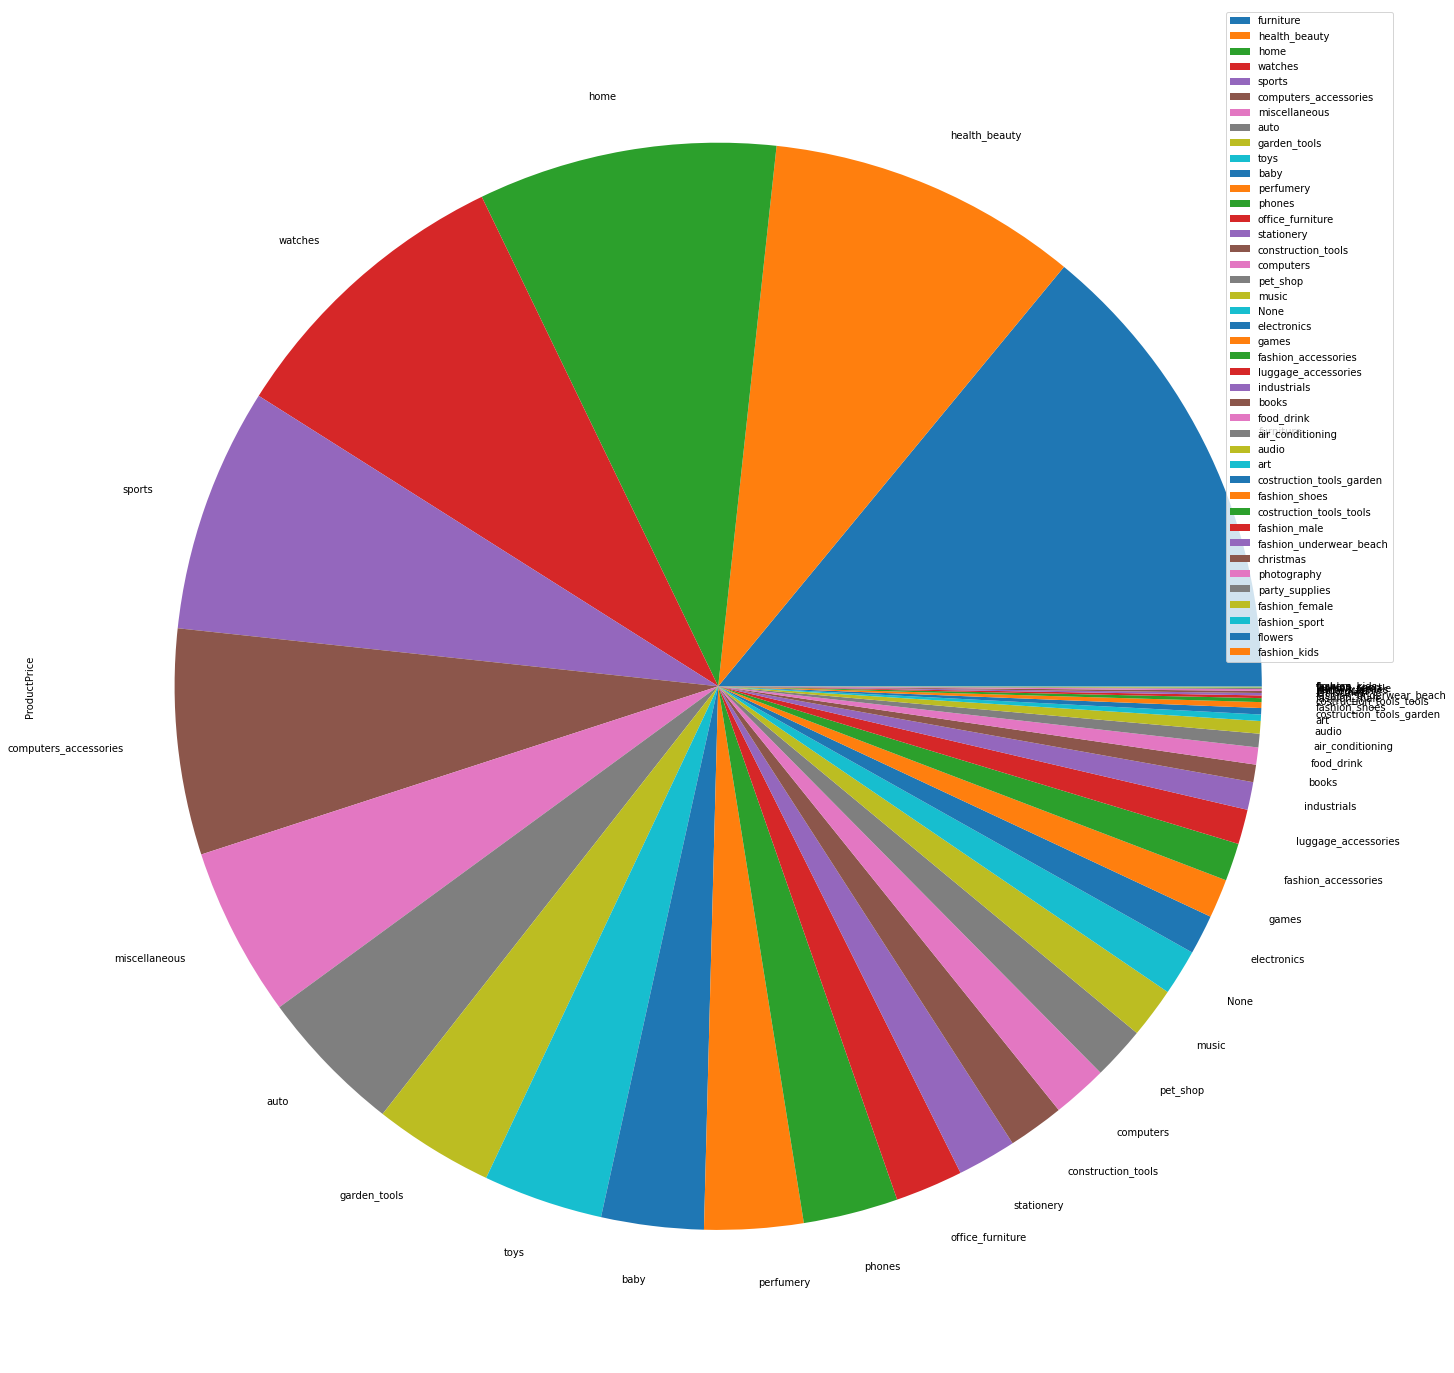

In [54]:
df_view=df_view.set_index('category')
df_view.plot.pie(y='ProductPrice', figsize=(25,25) )
plt.show()

## Insights 
- More than 50% of the spend comes from only 6 out of 42 categories.
- To increase spend, we can either double down on efforts in these 6 categories. 
- Alternatively, we could focus our efforts on gaining more spend in the lower spend categories. 
- Both are viable decisions and needs more context to determine. so we can focus on these. 
- The top 6 categories are furniture, health_beauty, home, watches, sports, computers_accessories. 

## (iii). Calculating the Avg # of Photos by Category

In [55]:
# Define a SQL (SQLite3) query
query = """
SELECT sum(number_of_photos)/count(product_id) as PhotosAvg, category
from prod
group by category
order by 1 desc
"""

# Run and/or print the query
df_view = sqldf.run(query) 
print(df_view)

    PhotosAvg                  category
0           5             fashion_shoes
1           3   fashion_underwear_beach
2           3              fashion_kids
3           2                   watches
4           2                      toys
5           2                stationery
6           2                    sports
7           2               photography
8           2                    phones
9           2                  pet_shop
10          2                     music
11          2             miscellaneous
12          2       luggage_accessories
13          2               industrials
14          2                      home
15          2              garden_tools
16          2                     games
17          2             fashion_sport
18          2            fashion_female
19          2       fashion_accessories
20          2   costruction_tools_tools
21          2  costruction_tools_garden
22          2        construction_tools
23          2                 computers


## (iv). Calculating Time Between Purchase and Delivery

In [56]:
# Avg_Delivery_Time is in Days
# Define a SQL (SQLite3) query
query = """
SELECT sum(julianday(delivered_at) - julianday(purchased_at))/count(distinct(order_id)) as avg_delivery_time, MonthYear
from odmy
where delivered_at IS NOT NULL
GROUP BY 2
ORDER BY strftime('%Y', odmy.purchased_at), strftime('%m', odmy.purchased_at)
--limit 5
"""

# Run and/or print the query
df_view = sqldf.run(query) 
print(df_view)

    avg_delivery_time MonthYear
0           54.813194   09-2016
1           19.578572   10-2016
2            4.693021   12-2016
3           12.647044   01-2017
4           13.168825   02-2017
5           12.951184   03-2017
6           14.917913   04-2017
7           11.322363   05-2017
8           12.011573   06-2017
9           11.592732   07-2017
10          11.147125   08-2017
11          11.851007   09-2017
12          11.856700   10-2017
13          15.161132   11-2017
14          15.394919   12-2017
15          14.080563   01-2018
16          16.947143   02-2018
17          16.301410   03-2018
18          11.499241   04-2018
19          11.419029   05-2018
20           9.239216   06-2018
21           8.958636   07-2018
22           7.732780   08-2018


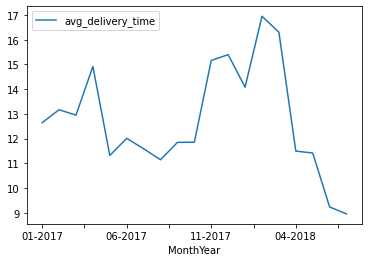

In [57]:
df_view.drop([0,1,2, 22], inplace = True) #Removing first three months and 08-2018 (outlier data)
df_view.plot(x ='MonthYear', y='avg_delivery_time', kind = 'line')

plt.show()

## Insights
- Avg Delivery Time is variable but window is around 1 business week. 
- Something the company can work on streamlining in the future but needs more information to be recommended right now. 

## IV. Conclusion

- Customer spend is on the rise
- The customer spend growth rate can be increased by focusing on increasing AOV and repeat customers. 
- There is some variance in shipping times, however, it is not addressed in the presentation. 
- Please look at the Presentation Deck for the C-Suite presentation